In [1]:
import timeit

import math
import fiona
import numpy as np
import osmnx as ox
import pandas as pd
import networkx as nx
import geopandas as gp
import matplotlib.pyplot as plt

from random import random
from queue import PriorityQueue
from shapely.ops import nearest_points
from shapely.geometry import Polygon,Point, MultiPoint, box
from skgeom import Point2,Segment2,arrangement,intersection,RotationalSweepVisibility, draw

%matplotlib inline

np.random.seed(27) # 21 for 1200 0.88

In [2]:
from QDforMLV import QDkAlgo

from helpers import *

In [3]:
'''
    Division_of_T()
'''
def divideTarget(Target, numPortions):
    pLen = Target.length / numPortions
    tvx = list(Target.exterior.coords)
    portions = []

    for i in range(len(tvx)-1):
        sideLen = np.sqrt( (tvx[i][0]-tvx[i+1][0])**2 + (tvx[i][1]-tvx[i+1][1])**2 )
        # print(sideLen)
        pN = sideLen / pLen
        pN = (int)(pN+0.5)
        xPL = (tvx[i][0]-tvx[i+1][0])/pN
        yPL = (tvx[i][1]-tvx[i+1][1])/pN
        # print(xPL,yPL)
        for pn in range(pN):
            portions.append(Segment2(Point2(tvx[i][0]-pn*xPL,tvx[i][1]-pn*yPL), Point2(tvx[i][0]-(pn+1)*xPL,tvx[i][1]-(pn+1)*yPL)))

    return portions


In [4]:
gdf = gp.read_file("datasets/obstacles400.gpkg")
qpGdf = gp.read_file("datasets/querypoints400.gpkg")

In [5]:

'''
    Visibility skgeom construction
'''
minx, miny, maxx, maxy = qpGdf.total_bounds*10000
minx-=10
miny-=10
maxx+=10
maxy+=10
outer = [
    Segment2(Point2(minx,miny), Point2(minx,maxy)), Segment2(Point2(minx,maxy), Point2(maxx,maxy)),
    Segment2(Point2(maxx,maxy), Point2(maxx,miny)), Segment2(Point2(maxx,miny), Point2(minx,miny))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

Boundary = Polygon([(minx,miny),(minx,maxy),(maxx,maxy),(maxx,miny)])


In [6]:
'''
    Preprocessing our obstacle GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''
gdf.drop(gdf[gdf['geometry'].type == 'Point'].index.values, inplace=True)
# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.7)
print(gdf.shape)

(74, 60)


In [7]:
'''
    Building TARGET.
    We store a simple shapely polygon and the polygon formed from the portions for the vis ops.
'''
# Random Target
Target = gdf.sample(n=1)

# Specific Target
# Target = gdf.loc[gdf['name'] == 'Museum of Contemporary Art'] # comment frac.

gdf.drop(Target.index, inplace=True)

In [8]:
'''
    Inserting Target in our arrangement
'''
targetVx = Target.geometry.exterior.iloc[0].coords
targetBuilder = []

for i in range(len(targetVx)-1):
    targetBuilder.append(Segment2(Point2(targetVx[i][0]*10000,targetVx[i][1]*10000), Point2(targetVx[i+1][0]*10000,targetVx[i+1][1]*10000)))

targetPolyBuilder = []
for i in range(len(targetVx)-1):
    targetPolyBuilder.append(Point(targetVx[i][0]*10000,targetVx[i][1]*10000))

scaledTarget = Polygon(targetPolyBuilder)
portions = divideTarget(scaledTarget, 31)

for bounds in targetBuilder:
    arr.insert(bounds)

# for bounds in portions:
#     arr.insert(bounds)

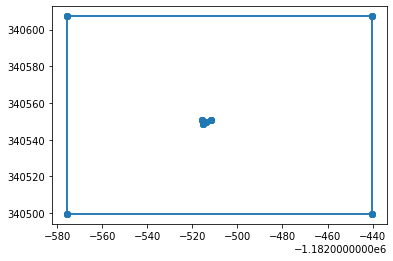

In [9]:
for he in arr.halfedges:
    draw.draw(he.curve())

In [10]:
treeNodes = []
for rtn in gdf.sindex.leaves():
    for rt in rtn[1]:
        treeNodes.append(rt)

print('No of obstacles:', len(treeNodes))

No of obstacles: 73


[9, 1, 22, 19, 21, 17, 2, 4, 8, 5, 15, 12, 3, 13, 0, 20, 23, 14, 16, 18, 10, 11, 7, 6]
[6.714587, 5.968774, 4.596749, 2.877735, 1.546325, 1.02741, 1.007236, 0.622524, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


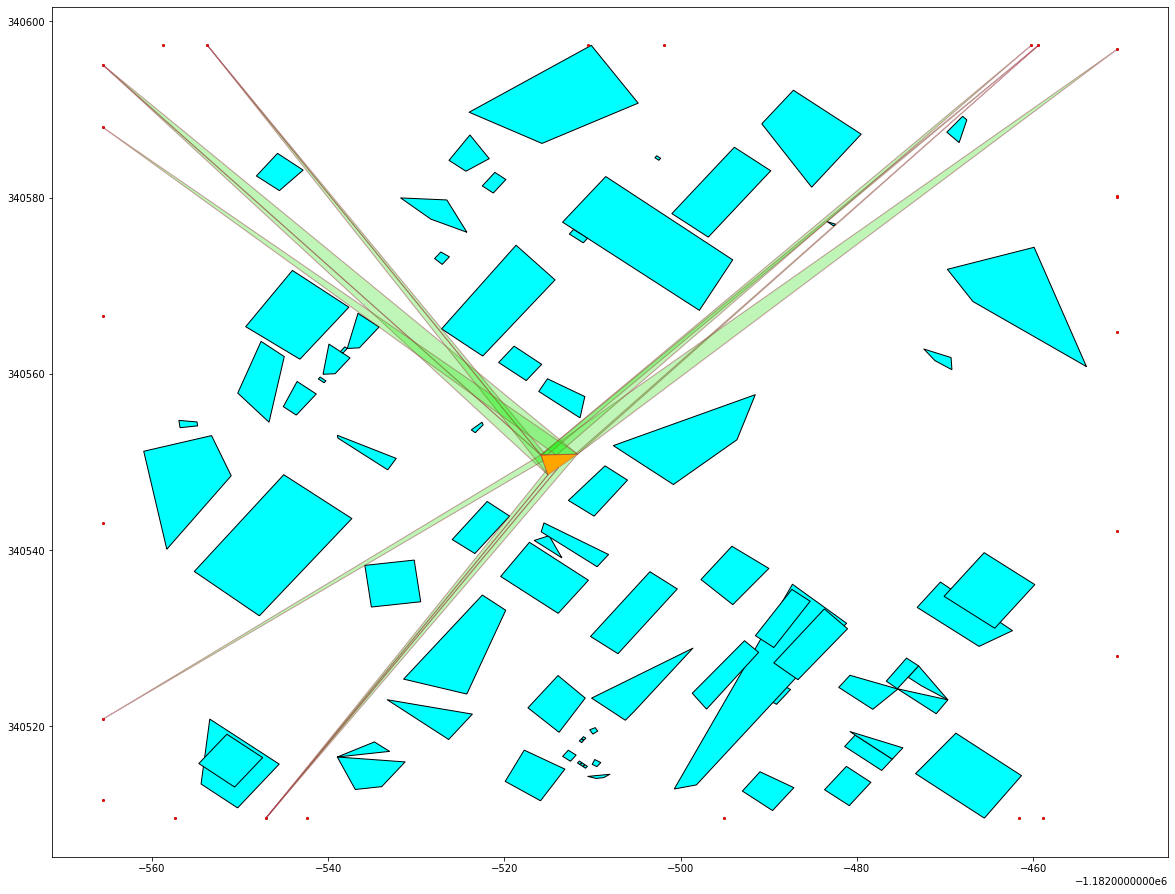

In [13]:
ans, ans_vis, ans_vrPoly, vrPolygons, vrSets = QDkAlgo(targetBuilder,outer, qpGdf, len(qpGdf.index), gdf,Boundary)
print(list(ans))
print(list(ans_vis))
plotFinal(scaledTarget,gdf.sindex,gdf,qpGdf,vrPolygons,ans_vrPoly,ans)

In [12]:
# vrSets

In [13]:
'''
    get portions by intersecting vrsets and Target
'''

'\n    get portions by intersecting vrsets and Target\n'